# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import random
import time  
import copy
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
from ddpg_agent import Actor, Critic, Agent
import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="data/Tennis_Linux/Tennis.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# from ddpg_agent import Agent



In [8]:
# actor_model = Actor(state_size, action_size, 1)
# x = Variable(torch.randn(1,state_size))
# y = actor_model(x)
             
# make_dot(y, params=dict(list(actor_model.named_parameters())))

In [9]:
# critic_model = Critic(state_size, action_size, 1)
# s = Variable(torch.randn(1,state_size))
# a = Variable(torch.randn(1,action_size))
# y = critic_model(s,a)
             
# make_dot(y, params=dict(list(critic_model.named_parameters())))


In [10]:
agents = []
for i in range(num_agents):
    agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=4))

In [11]:
def checkpoint(agents):
    for idx, agent in enumerate(agents):
        actor_local_name = 'checkpoint_actor_local_' + str(idx) + '.pth'
        critic_local_name = 'checkpoint_critic_local_' + str(idx) + '.pth'           
        actor_target_name = 'checkpoint_actor_target_' + str(idx) + '.pth'
        critic_target_name = 'checkpoint_critic_target_' + str(idx) + '.pth'            
        torch.save(agent.actor_local.state_dict(), actor_local_name) 
        torch.save(agent.critic_local.state_dict(), critic_local_name)             
        torch.save(agent.actor_target.state_dict(), actor_target_name) 
        torch.save(agent.critic_target.state_dict(), critic_target_name)

In [12]:
import time

def maddpg(n_episodes=2500, max_t=1000, print_every=100, num_learn=4, goal_score=0.5):
    scores_deque = deque(maxlen=100)                                        # create the score list
    all_scores = []                                                         # create the score list to plot
    all_avg_score = []                                                      # create the average score list to plot
    total_time = 0                                                          # set timer

    for i_episode in range(1, n_episodes+1):                                # set episode
        env_info = env.reset(train_mode=True)[brain_name]                   # reset the environment
        states = env_info.vector_observations                               # get the starting state
        scores_agents = np.zeros(num_agents)                                # initialize the agent score with zero
        start_time = time.time()                                            # begin train time for every episode

        while(True):
            actions = np.random.randn(num_agents, action_size)              # initialize the action list

            for idx in range(num_agents):
                agents[idx].reset()                                         # reset each agent
                actions[idx] = agents[idx].act(states[idx])                 # select action for each agent

            env_info = env.step(actions)[brain_name]                        # send all actions to tne environment
            next_states = env_info.vector_observations                      # get accordingly the next state
            rewards = env_info.rewards                                      # get the reward

            dones = env_info.local_done                                     # see if episode finished

            for idx in range(num_agents):
                agents[idx].step(states, actions, rewards, next_states, dones, i_episode, num_learn) # send s, a, r, ns, dones, i_episode, num_learn to each agent

            scores_agents += rewards                                        # update the score (for each agent)
            states = next_states                                            # roll over states to next time step

            if np.any(dones):
                break

        episode_score = np.max(scores_agents)                               # get the max score achieve over all the agents
        all_scores.append(episode_score)                                    # collect the max score into the list
        scores_deque.append(episode_score)                                  # 100 limit scores
        avg_score = np.mean(scores_deque)                                   # calculate the average of the last 100 score
        all_avg_score.append(avg_score)                                     # collect all the averages
        end_time = time.time() - start_time                                 # end time
        total_time += end_time                                              # collect every time in episode


        if i_episode % print_every == 0:                                    # every 100 episode check point
            print('Episode {}, Total Average Score: {:.2f}, Max Score: {:.2f}, Total Time: {:.2f}second'.format(i_episode, avg_score, np.amax(scores_deque), total_time))
            checkpoint(agents)

        if avg_score > goal_score:                                          # end the episode check point
            print("The Environment has been solved in {} Episode, with Average Score : {:.2f}".format(i, avg_score))
            checkpoint(agents)
            break
            
    return all_scores, all_avg_score

a_score, a_all_avg_score = maddpg()

Episode 100, Total Average Score: 0.01, Max Score: 0.10, Total Time: 27.57second
Episode 200, Total Average Score: 0.00, Max Score: 0.10, Total Time: 57.14second
Episode 300, Total Average Score: 0.02, Max Score: 0.20, Total Time: 99.71second
Episode 400, Total Average Score: 0.04, Max Score: 0.20, Total Time: 145.15second
Episode 500, Total Average Score: 0.05, Max Score: 0.20, Total Time: 189.12second
Episode 600, Total Average Score: 0.07, Max Score: 0.30, Total Time: 254.22second
Episode 700, Total Average Score: 0.09, Max Score: 0.20, Total Time: 333.63second
Episode 800, Total Average Score: 0.14, Max Score: 0.50, Total Time: 438.59second
Episode 900, Total Average Score: 0.15, Max Score: 0.59, Total Time: 559.79second
Episode 1000, Total Average Score: 0.23, Max Score: 1.00, Total Time: 741.33second
Episode 1100, Total Average Score: 0.30, Max Score: 1.20, Total Time: 959.42second
The Environment has been solved in 1 Episode, with Average Score : 0.51


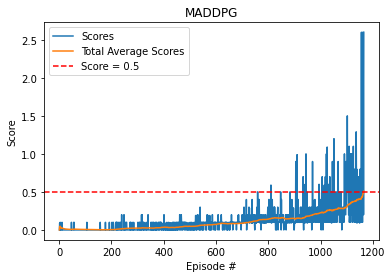

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(a_score)+1), a_score, label='Scores')
plt.plot(np.arange(1, len(a_score)+1), a_all_avg_score, label='Total Average Scores')
plt.title("MADDPG")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(y=0.5, color='r', linestyle='--', label='Score = 0.5')
plt.legend(loc='best')
plt.savefig('MADDPG.png')
plt.savefig('MADDPG.pdf')
plt.show()

In [14]:
agents[0].actor_local.load_state_dict(torch.load('checkpoint_actor_local_0.pth', map_location='cpu'))
agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_local_0.pth', map_location='cpu'))
agents[1].actor_local.load_state_dict(torch.load('checkpoint_actor_local_1.pth', map_location='cpu'))
agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_local_1.pth', map_location='cpu'))

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions1 = agents[0].act(states, False)            # select actions from loaded model agent
        actions2 = agents[1].act(states, False) 
        env_info = env.step(actions1,actions2)[brain_name] # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.650000039488077


In [15]:
env.close()